<a href="https://colab.research.google.com/github/Mohamedelrefaie/PytorchNoteBook/blob/master/tutorial2_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2 - Intro to Machine Learning and basic Neural Networks

In this tutorial, you will implement all components of a simple neural network in Numpy. By training the neural network, you will familiarize yourself with machine learning problems and how to solve them.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

We will again mount the Google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/DL_tutorials/tutorial2')

### Generate sample datasets
Feel free to skip reading the code of the cell below. These are just some helper functions for plotting and data generation.

In [ ]:
def getToyData(N, D, K):
    np.random.seed(0)
    centers = []
    for i in range(K):
        centers.append([np.random.randint(0,10),np.random.randint(0,10)])
        
    samples, labels = make_blobs(N, D, centers=tuple(centers),random_state=0)
    return samples, labels

def getSpiralToyData(N, D, K):
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1,N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return X, y

# Plotting decision regions
def plotDecisionBoundary(X, predict, pytorch_model_given=False):
  
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))


    data = np.c_[xx.ravel(), yy.ravel()]
    preds = None
    if pytorch_model_given:
      data = torch.from_numpy(data).float()

    preds = predict(data)

    if pytorch_model_given:
      preds = torch.argmax(preds, 1)
      preds = preds.detach().numpy()    
    
    #preds = np.argmax(scores,axis=1)
    Z = preds.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolor='k')
    ax.set_title('Learned Decision Boundary')

    plt.show()



def plotLossHistory(history):
    plt.title('Loss History')
    plt.ylabel('loss')
    plt.xlabel('Iteration')
    plt.plot(history)


#### Plot dataset


(100, 2)
[0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1
 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1
 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0]


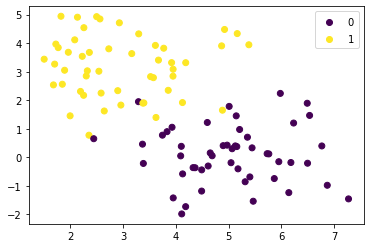

In [ ]:
# Dimensionality of the dataset --> important boundary condition for the network
N = 100 # number of samples
D = 2 # dimensionality: 2 input features
K = 2 # number of classes

X, y = getToyData(N, D, K)  # generate data
print(X.shape)  # 2 input features for each sample
print(y)  # class for each sample
fig, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
ax.legend(*scatter.legend_elements())
plt.show()

We will try to classify these points in the artificial dataset. In the big picture, these points will later represent images, texts, audios, etc.

## A simple neural network

We want to classify the points above according to their classes(0, 1). Let's see how PyTorch, the deep learning framework, can do it with very few lines of code.


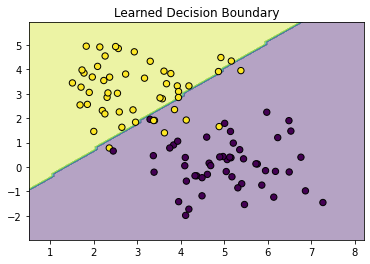

In [ ]:
import torch
import torch.nn as nn # neural network module
import torch.optim as optim # optimizer module
torch.manual_seed(10) # use arandom seed to make experiment reproducible

# PyTorch works with its own dataclass: torch tensors.
X_gpu = torch.from_numpy(X).float() #  convert numpy CPU tensor into a PyTorch tensor
y_gpu = torch.from_numpy(y)

# initialize components of learning pipelines: Are intialized as instances of respective classes!
neural_net = nn.Linear(in_features=D, out_features=K) # Fully connected neural network with D=2 input features and K=2 classes.
optimizer = optim.SGD(params=neural_net.parameters(), lr=1e-5) # stochastic gradient descent optimizer with learning rate 10^(-5)
criterion = nn.CrossEntropyLoss() # loss function

# forward
outputs = neural_net(X_gpu) # forward pass
loss = criterion(outputs, y_gpu) # calculate loss

loss.backward() # backward pass: We call the instance method 'backward' of our loss instance to compute the gradient
optimizer.step() # update neural net with gradiens using the instance method 'step' of our optimizer instance
# it should be apparent why we had to initialize the optimizer instance above with all neural network parameters

predictions = torch.argmax(neural_net(X_gpu), 1) # Get predictions on data after training


plotDecisionBoundary(X, neural_net.forward, pytorch_model_given=True)

As you can see, we were able to classify most of the points using a very simple fully connected neural network with no hidden layers and with only 1 SGD update step. Observe the following tasks tackled by high level PyTorch functions. 

- A neural network model with weights and biases:  `neural_net = nn.Linear(in_features=D, out_features=K)`
- An optimizer which takes the gradients and model parameters, then updates the model:<br/> `optimizer = optim.SGD(params=neural_net.parameters(), lr=1e-5)`
- A loss function: `criterion = nn.CrossEntropyLoss()`
- Forward pass of the network: `outputs = neural_net(X_gpu)`
- Loss calculation: `loss = criterion(outputs, y_gpu)`
- Calculating gradients (backward pass of the network): `loss.backward()`
- Updating parameters of the model with the optimizer: `optimizer.step()`

Easy? Right. Now, we will dive into each of these components to understand what's going on under the hood. We will implement these functionalities on a matrix multiplication level in Numpy.

## PyTorch vs Numpy

We will use Numpy to understand the underlying computations. Numpy is a generic computation library for Python whereas PyTorch is a deep learning focused framework with GPU acceleration. We need to run the computations on the GPU most of the time since the matrix multiplications we are dealing with are usually too extensive for a CPU.

## Correspondence of PyTorch and Numpy

Remember, a fully connected network (linear layer) can be created in PyTorch with `nn.Linear(in_features=D, out_features=K)`.

Let's implement the same thing in Numpy. We need to define the forward pass and the backward pass for each layer we implement. Look at the definition of the computations in the lecture slides. We (and you) will implement all functions to operate on a (mini-)batch of data for mini-batch gradient descent.

In [ ]:
# Fully Connected Layer (also referred to as affine layer):
# input: (N,D) - numpy array of inputs where N is the number of samples of dimension D
# weights: (D,H) - array of weights D - dimension of input layer , H - dimension of output layer
# bias: (H,) bias terms
# returns: (N,H) - affine operation result 
def linear_forward(X, W, b):
    # We implement the multiplication of weights (not biases) with the whole mini-batch 
    #       via a single matrix-matrix product
    # We use broadcasting over the batch-dimension for biases
    scores = np.dot(X, W) + b
    assert (scores.shape == (X.shape[0], W.shape[1]))
    return scores


# This function computes gradients of a linear forward function wrt its inputs (X, W, b)
# inputs (X, W, b) : cache saved during forward pass
# dout - (N,H) incoming local gradients of shape -  (N,H) 
# returns: dX - gradient wrt X with same shape as X - (N,D)  --> needed to propagate local gradients upstream
# returns: dW - gradient wrt W with same shape as W -(D, H)
# returns: db - gradient wrt b with same shape as b - (H)
##############
##############

# TODO: observe how gradients are computed - compare computation of weights gradient with slide 41 
# (no code writing necessary here)

##############
##############
def linear_backward(X, W, b, dout):
    dX = np.dot(dout, W.T)
    dW = np.dot(X.T, dout)
    db = np.sum(dout, axis=0)
    return dX, dW, db


## Verify Gradients
We can use a Finite Difference approximation to check the implementation of the backward pass. This is a common method to check if a model is implemented correctly and one of the first things to consider whenever a neural network is not learning properly.
If the implementation is correct, the relative error between the Finite Difference approximation and
the analytic gradients computed by Backpropagation should be less than 1e-6 for each of W and b. 
The Finite Difference Scheme is already implemented for you. 


In [ ]:
# some helper methods to evaluate numerical gradient
from gradient_check import eval_numerical_gradient_array
from gradient_check import eval_numerical_gradient

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

#### Test fully connected forward and backward functions

In [ ]:
x = np.random.randn(10, 6)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: linear_forward(x, w, b), x, dout)
dw_num = eval_numerical_gradient_array(lambda w: linear_forward(x, w, b), w, dout)
db_num = eval_numerical_gradient_array(lambda b: linear_forward(x, w, b), b, dout)


dx, dw, db = linear_backward(x, w, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  5.77576886607126e-10
dw error:  5.803530379495435e-11
db error:  5.672728185971e-12


We have implemented both forward pass and backward pass for fully connected (affine) layer. It has the same functionality as `nn.Linear(in_features=D, out_features=K)` in PyTorch.

## ReLU
Now, it's your turn. Implement the forward pass and backward pass of ReLU using the code below. Note: Set gradient = 0 if x = 0. 

The derivative is simple, remember that ReLU is a picewise linear function and the derivative of a line is a very simple calculation.

In [ ]:
# ReLU activation
# input (N,H) - output of fully connected layer, where N is number of samples in the mini-batch and H is hidden layer size
# return (N,H) - ReLU activated outputs
# Hint: In Python, boolean True is treated as 1 and boolean False is treated as 0.
#       It will be cast accordingly when applying arithmetic operators together with int/floats
def relu_forward(inputs):
    out = None
    ##############
    ##############

    # TODO: apply the ReLU activation function to the inputs and save the obtained value in the variable 'out'
    out = (inputs > 0) * inputs

    ##############
    ##############
    return out


# compute gradient of ReLU function
# input:  dout - (N,D) back-flowing local gradients
# returns: out - (N,D) gradient of ReLU wrt its input from last affine layer 
def relu_backward(cache, dout):
    inputs = cache  # we saved the inputs into ReLU (i.e. z)  during the forward pass
    out = None
    ##############
    ##############

    # TODO: compute the gradient of ReLU activation function and save the obtained value in the variable 'out'
    out = (inputs > 0) * dout

    ##############
    ##############
    assert (out.shape == dout.shape)
    return out


#### Test relu forward and backward functions

Now you can verify if your ReLU backward implementation is correct by comparing with the numerical gradient as we did previously.

In [ ]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x), x, dout)
dx = relu_backward(x, dout)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756201921578e-12


Now, we have implemented the equivalent of `nn.ReLU()` in PyTorch!

## Softmax

Let's implement only the forward pass of Softmax and Cross Entropy Loss. We'll implement the backward pass later on. We will provide the code for the Softmax. Check the code carefully. Then implement the forward pass of Cross Entropy Loss using the softmax we've provided. 

In [ ]:
# Softmax: Normalize the predicted logits to per class probability
# Logits refers to pseudo-probabilities, i.e. probability-like values that are not scaled to a range of [0,1]
# The scaling to a range of [0,1] will be done using the softmap function.

# logits: (N,K) - numpy array of logits, where N is the number of samples and K is the number of classes
# returns: (N,K) - class probabilities 
def softmax(logits):
    # probs = np.exp(logits)  # might experience overflow
    # better: softmax(x + c) = softmax(x) --> we can subtract maximum to avoid numerical overflow
    probs = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    assert (probs.shape == logits.shape)
    return probs

In [ ]:
# Categorical cross entropy loss
# logits (N,K) - class logits where N is number of samples and K is the number of classes
# y (N,) - true class for each sample, where N is the number of samples
# return loss - scalar categorical cross entropy loss
# Note: input is logits per class, not probabilities
# Hint: first use softmax for per class probabilities
# Hint: use loss equation in blue boxes on slide 27
# Hint: use my_probability_array[np.arange(N), y] to select probabilities of the true class (see what is does!)
def cross_entropy_loss(logits, y):
    loss = None
    N = logits.shape[0]
    ##############
    ##############

    # TODO: compute the cross entropy loss and save it in the variable 'loss'
    probs = softmax(logits)
    positive_probabilities = probs[np.arange(N), y]  # selects predicted probabilitiy of true class (for both samples)
    loss = np.mean(-np.log(positive_probabilities))

    ##############
    ##############
    return loss

# Gradient of loss function wrt logits predicted for each class
# input : logits - (N,K)
# input : y - true class labels of size (N)
# returns: out - gradient of loss wrt. logits of size (N,K)
# Note: using the chain rule and some nice simplifications allows computation of the categorical cross entropy loss
#       just as a function of softmaxes
def cross_entropy_backward(logits, y):
    N = logits.shape[0]
    probs = softmax(logits)
    out = probs.copy()
    out[np.arange(N), y] -= 1
    out /= N
    assert (out.shape == logits.shape)
    return out

Now we have implemented `cross_entropy_loss` corresponding to `criterion = nn.CrossEntropyLoss()` in our first PyTorch example.

### An Example for predicting the class of a sample

For simplicity, let's consider a linear multi-output perceptron (slide 14), i.e. no hidden layer and no activation function.

If you've implemented `cross_entropy_loss` correctly, the loss in the example is approx. 1.596.

In [ ]:
# Two points [3, 3] and [6, 0] that we want to classify: Our network processes the batch of data simultaneously
x = np.asarray([[3, 3],[6, 0]]) # two 2-dimensional samples
y = np.asarray([1, 0]) # class labels for these two points


# the goal is to make the network learn weights that best classify our data
# we start with random weights
np.random.seed(0)
W = np.random.randn(D, K)
b = np.random.randn(K)

# calculate logits: only single linear layer
logits = linear_forward(x, W, b)

# select classes with highest logits - is equivalent to highest class probability as softmax only re-scales
predicted_class = np.argmax(logits, axis=1)
print ('predicted class {0} for the point {1}'.format(predicted_class[0], x[0, :]))

# we can also output probabilities
probs = softmax(logits)
print('Prediced Probabilities:\n', probs)

# calculate loss for predicted probabilities
loss = cross_entropy_loss(logits, y)
print ('loss: ', loss)


predicted class 0 for the point [3 3]
Prediced Probabilities:
 [[9.58910914e-01 4.10890860e-02]
 [9.99983763e-01 1.62369194e-05]]
loss:  1.5960144888345227


## Backpropagation

Note: The untrained network confidently predicts both samples to belong to class 0 (with 95.8% / 99.9%).
We need to update the weights such that the sample [3, 3] is correctly predicted to be from class 1.

We minimize the loss iteratively using gradient descent. We take the derivative of the loss function such that we can update the weights to move the loss downhill.

### Run backward pass to calculate gradients for weights and update the weights
We'll simulate the behavior of `optimizer` in PyTorch.
We've already implemented backward functions for `cross_entropy` and `linear`. <br/> TODO: Run one backward pass over the network and update the weights.

0. Start from the `logits` predicted in the forward pass above and labels `y`
1. Feed them into cross_entropy alongside their labels
2. Store the gradients from cross_entropy, then feed them to the linear layer alongside its input, weights and biases.
3. Update the network with the given learning rate

Hint: Look at the function definitions of `cross_entropy_backward` and `linear_backward` above.

In [ ]:
learning_rate = 0.4

##############
##############

# TODO: run one backward pass over the network and update the weights
dout = cross_entropy_backward(logits, y)  # local gradients wrt. loss function
dX, dW, db = linear_backward(x, W, b, dout)  # gradients wrt. weights, taking the local gradients as input
# update the weights: walk in the negative direction of the gradient
W -= learning_rate * dW
b -= learning_rate * db

##############
##############

You can check if your implementation is correct by comparing your predicted probability for class 1 with the given value in the cell below.

#### Calculate new per class scores with updated weights

In [ ]:
logits = linear_forward(x, W, b)
probs = softmax(logits)

predicted_class = np.argmax(probs, axis=1)

# now calcualte loss
loss = cross_entropy_loss(logits, y)

# print results
print('Prediced Probabilities:\n', probs)
print ('Predicted class {0} for {1} '.format(predicted_class[0], x[0]))
print ('loss: ', loss)

Prediced Probabilities:
 [[0.01571122 0.98428878]
 [0.97681347 0.02318653]]
Predicted class 1 for [3 3] 
loss:  0.019647762079878173


One step in negative gradient direction yielded new weights resulting in a reduced loss. Now the network correctly predicts that [3, 3] belongs to class 1 (with probability 98.4%). Note that, in general, much more than 1 gradient descent step is needed.

We have just implemented the following parts in the initial PyTorch example with Numpy. 

`loss.backward() # backward pass`

`optimizer.step() # update neural net with gradients`

#### Run Gradient Descent on complete data

We've now accomplished to learn from 2 samples. Even though our network can correctly classify these 2 examples, we really want the algorithm to learn to classify
all examples in the dataset. We therefore compute gradients from more examples and  use them to iteratively apply the weight updates, until there is no more improvement.


In [ ]:
##############
##############

# TODO: Try changing the parameters 'N', 'K', 'num_iters', 'learning_rate' and observe how these changes influence the training process


N = 200 # number of samples
K = 2 # number of classes

D = 2
X, y = getToyData(N, D, K)

np.random.seed(0)
W = np.random.randn(D,K)
b = np.random.randn(K)

num_iters = 20  # number of iterations
learning_rate = 0.1
loss_history = []

##############
##############

# observe how the whole learning pipeline is implemented
for i in range(num_iters):
    # Forward pass
    logits = linear_forward(X, W, b)
    loss = cross_entropy_loss(logits, y)
    loss_history.append(loss)

    # Backward pass
    dout = cross_entropy_backward(logits, y)
    dX, dW, db = linear_backward(X, W, b, dout)

    # update the weights
    W -= learning_rate * dW
    b -= learning_rate * db


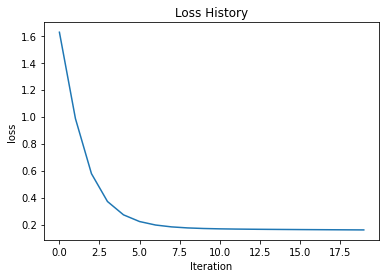

In [ ]:
plotLossHistory(loss_history)

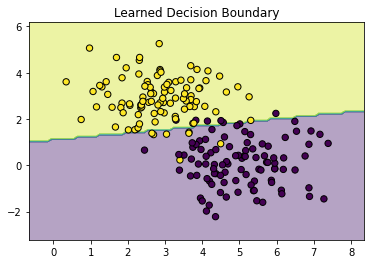

In [ ]:
# plot the learned decision region. Samples inside this region will be assigned the respectively colored class.
predict = lambda x: np.argmax(linear_forward(x, W, b), axis=1)
plotDecisionBoundary(X, predict)

## Develop a Neural Network 

We have just developed the individual components that are part of the learning algorithm. Now we need to arrange them to have a more consistent interface allowing for a flexible definition of more advanced neural network architectures. The components of neural networks are best defined in terms of layer-by-layer operations. Each layer receives its input from the previous layer, performs some operations and passes the results to the next layer. It's best practice to structure layers in classes to have forward and backward functions stored together. This also allows easy caching of computed values during the forward pass for re-use in Backpropagation.

### Define layers

Let's define a class called `Linear` in Numpy.

In [ ]:
class Linear:
    def forward(self, inputs, weights, bias):
        self.cache = (inputs, weights, bias)  # save inputs into affine layer for later use in Backprop
        # using class attributes for this purpose is very handy as other functions of the class 
        #   automatically have access to these values
        return linear_forward(inputs, weights, bias);
    
    def backward(self, dout):
        inputs, weights, bias = self.cache # retrieve inputs that were saved during forward pass
        dX, dW, db =  linear_backward(inputs, weights, bias, dout)
        return dX, dW, db
    

In PyTorch, we can call already defined layers. If we were to implement the linear layer as above with tensor operations we'd do it as follows (A more detailed PyTorch intro will be given in next tutorial, just try to understand the big picture for now).

In [ ]:
class PyTorchLinear(nn.Module):
    def __init__(self, in_features, out_features):
        
        # Initialize weights and biases in Constructor
        # nn.Parameter is a class for variables that will be optimized: 
        #    They are tracked by autograd to automatically compute gradients
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        # weights and biases are stored conveniently as class attributes inside each layer instance
    
    def forward(self, input):
        scores = torch.mm(input, self.weight) + self.bias # mm: matrix multiplication; same as in linear_forward
        return scores

Observe the differences: The most notable one is that we did not compute the backward explicitly. This is one of the most powerful features of deep learning frameworks. When you implement new layers you don't compute gradients manually, which might be very hard for complicated networks.
In PyTorch, a method called *autograd* keeps a record of data (tensors) and all executed operations on them to compute the gradients using the chain rule. 

Nevertheless, it's very important to learn how gradients are computed and backpropogation works. It helps when designing new layers or finding out possible bottlenecks or bugs in the program.


Let's continue defining other layers. 

In [ ]:
class Relu:
    
    def forward(self, inputs):
        self.cache = inputs
        out =  relu_forward(inputs);
        return out
    
    def backward(self, dout):
        out =  relu_backward(self.cache, dout)
        assert(out.shape == dout.shape)  # verify out shape
        return out

**TODO:** Now fill in missing parts in the code below to define a CrossEntropyLoss class.

In [ ]:
class CrossEntropyLoss:
    
    # inputs: shape(N,K) unnormalized class scores
    # y: shape (N) - true class labels
    def forward(self, logits, y):
        ##############
        ##############

        # TODO: calculate the cross entropy loss
        out = cross_entropy_loss(logits, y)

        ##############
        ############## 
        self.cache = (logits, y)
        return out
    
    def backward(self):
        ##############
        ##############

        # TODO: calculate the cross entropy loss backward
        # Hint: use self.cache
        logits, y = self.cache
        out = cross_entropy_backward(logits, y)

        ##############
        ############## 
        assert(out.shape == logits.shape)
        return out

### Define a simple Softmax Classifier using the defined Layers
It is common to define a neural network model in a class for easy initialization, forward and backward passes. Complete the multi-output perceptron class below. If it trains properly, you will notice it in the resulting plot and then you know if you've successfully implemented the class. <br/>Hint: Use the layer classes defined above and the forward / backward functions they implement. You only need to think about what is input and output of each layer.

In [ ]:
# One layer classifier
class SoftmaxClassifier(object):
    def __init__(self, input_size, output_size, std=1e-2):
        self.loss_history = []
        self.params = {}
        self.params['W'] = std * np.random.randn(input_size, output_size)
        self.params['b'] = np.zeros(output_size)
        self.linear = None
        self.cross_entropy = None        
        ##############
        ##############

        # TODO: initialize linear and cross_entropy layers
        # Hint: even though we did not explicitly code the __init__() function, we can still
        #       call the class Constructor (with no inputs) to construct an instance of this class
        # Hint: store initialized layer instances as SoftmaxClassifier instance attributes
        self.linear = Linear()
        self.cross_entropy = CrossEntropyLoss()

        ##############
        ############## 
    
    # calculate loss
    def loss(self, X, y, reg=0.0):
        loss = None
        W, b = self.params['W'], self.params['b']
        ##############
        ##############

        # TODO: perform forward pass and compute loss
        logits = self.linear.forward(X, W, b)
        loss = self.cross_entropy.forward(logits, y)

        ##############
        ############## 
        return loss
    
    
    def calculate_grads(self):
        grads = {}
        dW = None
        db = None
        ##############
        ##############

        # TODO: compute loss backward and perform backward pass
        dout = self.cross_entropy.backward()
        dX, dW, db = self.linear.backward(dout)

        ##############
        ############## 
        grads['W'] = dW
        grads['b'] = db
        return grads
    
    
    # train using gradient descent
    # X - training data features
    # y - training data class labels
    # learning_rate - SGD step size
    # num_iters - number of iterations to run training
    # verbose - if true, print the loss values at every nth iteration
    def train(self, X, y, learning_rate=0.1, num_iters=100, verbose=True):
        
        for iteration in range(num_iters):
            loss = self.loss(X, y)
            grads = self.calculate_grads()
            self.loss_history.append(loss)
            ##############
            ##############

            # TODO: update the network parameters using new gradients
            self.params['W'] -= learning_rate * grads['W']
            self.params['b'] -= learning_rate * grads['b']

            ##############
            ############## 
            if verbose and iteration % 100 == 0:
                print('iteration %d / %d: loss %f' % (iteration, num_iters, loss))
        
    
    # predict class for each sample
    # inputs : samples of shape (N, D)
    # output : predictions of size (N) where for each prediction class should be 0<=prediction< K
    def predict(self,inputs):
        preds = None
        W, b = self.params['W'], self.params['b']
        ##############
        ##############

        # TODO: run forward pass and obtain predictions
        logits = self.linear.forward(inputs, W, b)
        preds = np.argmax(logits, axis=1)
        
        ##############
        ############## 
        return preds

Observe how easy training the classifier is, once we've created the SoftmaxClassifier class:

iteration 0 / 2000: loss 1.100613
iteration 100 / 2000: loss 0.920533
iteration 200 / 2000: loss 0.850972
iteration 300 / 2000: loss 0.818562
iteration 400 / 2000: loss 0.801345
iteration 500 / 2000: loss 0.791349
iteration 600 / 2000: loss 0.785170
iteration 700 / 2000: loss 0.781173
iteration 800 / 2000: loss 0.778496
iteration 900 / 2000: loss 0.776653
iteration 1000 / 2000: loss 0.775359
iteration 1100 / 2000: loss 0.774433
iteration 1200 / 2000: loss 0.773762
iteration 1300 / 2000: loss 0.773270
iteration 1400 / 2000: loss 0.772906
iteration 1500 / 2000: loss 0.772633
iteration 1600 / 2000: loss 0.772429
iteration 1700 / 2000: loss 0.772274
iteration 1800 / 2000: loss 0.772157
iteration 1900 / 2000: loss 0.772067


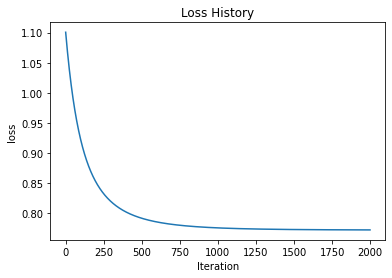

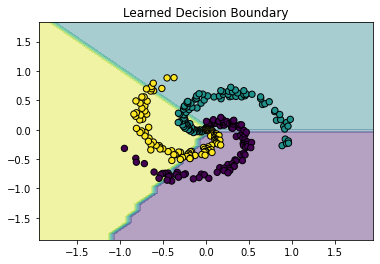

In [ ]:
# test it on the data
N = 100 # number of samples
D = 2 # dimensionality
K = 3 # number of classes

# generate spiraldata
X, y = getSpiralToyData(N, D, K)

# initialize classifier
softmaxClassifier = SoftmaxClassifier(D, K)

# train the classifier with the generated data
softmaxClassifier.train(X, y, num_iters=2000)

# plot the loss and decision boundary
plotLossHistory(softmaxClassifier.loss_history)
plotDecisionBoundary(X, softmaxClassifier.predict )

**TODO**: Analyze the decision boundary above. \
**Question**: Can we get a perfect decision boundary using this linear multi-output perceptron?


Your answer here!
* The data is not linearly separable.
* As we have no non-linearity in the network, the network can only learn linear functions of input variables
* The learned linear separation is visible in the plot above
* We can therefore not get a perfect decision bounary!

## Single Hidden Layer Network
Let's build a higher capacity neural network with a hidden layer and a ReLU activation function. 

You can check if your implementation is correct if you can learn properly on the dataset below. <br/>
Hint: The structure is the same as in the SoftmaxClassifier class above. Think about inputs and outputs of layers.

In [ ]:
# Two layer Neural Network
class NeuralNetwork(object):
    def __init__(self, input_size, hidden_size, output_size, std=0.01):
        self.loss_history = []
        
        # Initializing weights (similar to the PyTorch sample class)
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # we need 2 affine layers, 1 ReLU layer and the loss
        ##############
        ##############

        # TODO: initialize layers
        self.linear1 = Linear()
        self.linear2 = Linear()
        self.relu = Relu()
        self.cross_entropy = CrossEntropyLoss()

        ##############
        ##############         
        
    
    # calculate loss
    def loss(self, X, y):
        loss = None
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        ##############
        ##############

        # TODO: implement forward pass and calculate loss using cross entropy
        # Hint: forward pass = affine->relu->affine->softmax+loss
        o1 = self.linear1.forward(X, W1, b1)
        a1 = self.relu.forward(o1)
        a2 = self.linear2.forward(a1, W2, b2)
        loss = self.cross_entropy.forward(a2, y)

        ##############
        ##############    
        return loss
     
    
    def calculate_grads(self):
        grads = {}
        dW1, dW2, db1, db2 = None, None, None, None
        ##############
        ##############

        # TODO: do backpropagation layer by layer
        # Hint: forward pass = affine->relu->affine->softmax+loss
        # Hint: backward pass = affine_backward<-relu_backward<-affine_backward<-softmax+loss grad
        dloss = self.cross_entropy.backward()
        dhidden, dW2, db2 = self.linear2.backward(dloss)
        drelu = self.relu.backward(dhidden)
        _, dW1, db1 = self.linear1.backward(drelu)

        ##############
        ############## 
        grads['W1'] = dW1
        grads['b1'] = db1
        
        grads['W2'] = dW2
        grads['b2'] = db2
        return grads
    
    # predict class for each sample
    # inputs : shape (N, D)
    # output : class index prediction of size (N)
    def predict(self, inputs):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        o1 = self.linear1.forward(inputs, W1, b1)
        a1 = self.relu.forward(o1)
        logits = self.linear2.forward(a1, W2, b2)
        preds = np.argmax(logits, axis=1)
        return preds
        

### Let's define the same neural network as above, but using the PyTorch library
You only need to observe the code here. Notice the similarity of the neural network and layer classes with our custom implementation. Also notice how easily we can setup the network with the layer classes given by PyTorch.

#### Define Network Architecture

In [ ]:
class PyTorchNeuralNetwork(nn.Module):

    def __init__(self,input_size, hidden_size,output_size):
        super(NeuralNetwork, self).__init__()  # use constructor of superClass
        # initialize layers
        self.linear1 = nn.Linear(input_size, hidden_size)  
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        o1 = self.linear1(x)
        a1 = self.relu(o1)
        logits =  self.linear2(a1)
        return logits

We provide the training loop for convenience.

In [ ]:
# train using gradient descent
# network - NeuralNetwork class you implemented (not PyTorch)
# X - training data
# y - training data class labels
# num_iters - number of iterations to run training
# verbose - if true, print the loss values at every nth iteration
def train(network, X, y, learning_rate=0.01, num_iters=1000, verbose=True):
    
    for iteration in range(num_iters):
        loss = network.loss(X, y)
        grads = network.calculate_grads()
        network.loss_history.append(loss)            
        for param in network.params:  # iterate parameter dictionary to update each weight type
            network.params[param] -= learning_rate * grads[param]
        
        if verbose and iteration % 100 == 0:
            print('iteration %d / %d: loss %.3f' % (iteration, num_iters, loss))

iteration 0 / 10000: loss 1.099
iteration 100 / 10000: loss 1.095
iteration 200 / 10000: loss 1.068
iteration 300 / 10000: loss 0.937
iteration 400 / 10000: loss 0.774
iteration 500 / 10000: loss 0.715
iteration 600 / 10000: loss 0.697
iteration 700 / 10000: loss 0.688
iteration 800 / 10000: loss 0.681
iteration 900 / 10000: loss 0.676
iteration 1000 / 10000: loss 0.670
iteration 1100 / 10000: loss 0.664
iteration 1200 / 10000: loss 0.658
iteration 1300 / 10000: loss 0.651
iteration 1400 / 10000: loss 0.644
iteration 1500 / 10000: loss 0.636
iteration 1600 / 10000: loss 0.626
iteration 1700 / 10000: loss 0.615
iteration 1800 / 10000: loss 0.603
iteration 1900 / 10000: loss 0.589
iteration 2000 / 10000: loss 0.573
iteration 2100 / 10000: loss 0.555
iteration 2200 / 10000: loss 0.536
iteration 2300 / 10000: loss 0.516
iteration 2400 / 10000: loss 0.495
iteration 2500 / 10000: loss 0.474
iteration 2600 / 10000: loss 0.452
iteration 2700 / 10000: loss 0.431
iteration 2800 / 10000: loss 0.4

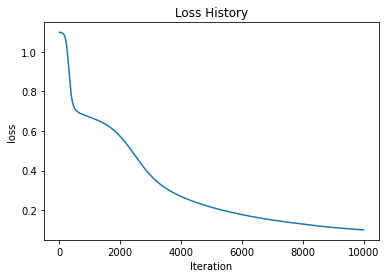

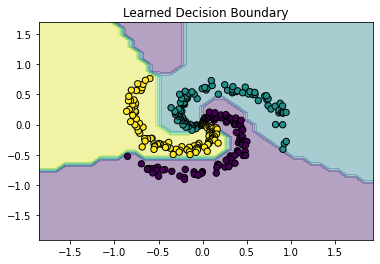

In [ ]:
N = 100 # number of samples
D = 2 # dimensionality
K = 3 # number of classes

# setup data
X, y = getSpiralToyData(N, D, K)

# define network
H = 100 # number of neurons in hidden layer
net = NeuralNetwork(D, H, K)

# train the network
train(net, X, y, learning_rate=1e-1,  num_iters=10000)

# plot the training loss
plotLossHistory(net.loss_history)
plotDecisionBoundary(X, net.predict )

### Analyze the decision boundary:
**Questions**: 

1) The addition of which specific layer improves the decision boundary? Was it the additional hidden layer or the activation function?

2) If we don't use any activation functions, and implement a very deep multi-layered network, what would the decision boundary look like?



Your answer here!
* The additional layer cannot be responsible for the non-linear decision boundary as stacked linear functions are still a linear mapping, irrespective of the number of layers.
* The ReLU activation yields piece-wise linear decision boundaries as the one above, allowing non-linear decision boundaries.

Congrats on implementing and training your first neural networks!